# Importing Libs and data

In [1]:
import os
import math
import random
import shutil
import tqdm
import joblib
import statistics
import re
import string

import tensorflow as tf
import numpy as np
import pandas as pd
from sklearnex import patch_sklearn
patch_sklearn()

import sklearn
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

import visualkeras

import keras
from keras import Sequential
from keras.layers import Dropout, BatchNormalization, Embedding, TextVectorization, GlobalAveragePooling1D
from keras.layers import Dense, GRU, SimpleRNN, LSTM, Bidirectional
from keras.utils import text_dataset_from_directory, pad_sequences, to_categorical
from keras.preprocessing.text import Tokenizer

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy, BinaryCrossentropy
# from keras.wrappers.scikit_learn import KerasClassifier

print(tf.config.list_physical_devices())

seed = 42

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
#For me to alert myself due to long training times
#Change the alert sounds to your liking
from pygame import mixer

def success():
    mixer.init()
    mixer.music.load('../alert_sounds/simple-notification-152054.mp3')
    mixer.music.set_volume(0.3)
    mixer.music.play()

def failure():
    mixer.init()
    mixer.music.load('../alert_sounds/wrong-answer-129254.mp3')
    mixer.music.set_volume(0.2)
    mixer.music.play()

success()

pygame 2.1.2 (SDL 2.0.18, Python 3.10.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
fp = './train.csv'
data = pd.read_csv(fp)
data

,Quotes
0,Embrace the beauty of every sunrise; it's a fr...
1,Embrace challenges; they are the stepping ston...
2,Embrace the rhythm of life and let it dance th...
3,"Embrace kindness, for it has the power to chan..."
4,"Embrace the journey, for it leads to the desti..."
...,...
995,"With an open heart, welcome the opportunities ..."
996,"This morning, let your laughter be the music t..."
997,"In the serenity of this morning, find the powe..."
998,"This morning, let your actions be a testament ..."


In [4]:
len(np.unique(data.Quotes))

890

# Preprocessing

## Vocab

In [5]:
data = list(data.Quotes)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data)
tokenizer.word_index

{'the': 1,
 'of': 2,
 'your': 3,
 'and': 4,
 'a': 5,
 'in': 6,
 'is': 7,
 'for': 8,
 'let': 9,
 'be': 10,
 'it': 11,
 'to': 12,
 'every': 13,
 'you': 14,
 'our': 15,
 'that': 16,
 'dance': 17,
 "life's": 18,
 'embrace': 19,
 'through': 20,
 'this': 21,
 'with': 22,
 'believe': 23,
 'are': 24,
 'radiate': 25,
 'yourself': 26,
 'morning': 27,
 'heart': 28,
 'will': 29,
 "planet's": 30,
 'they': 31,
 'love': 32,
 'life': 33,
 'kindness': 34,
 'dreams': 35,
 'symphony': 36,
 "singapore's": 37,
 'power': 38,
 'we': 39,
 'from': 40,
 'soul': 41,
 'find': 42,
 'world': 43,
 'gratitude': 44,
 'light': 45,
 'act': 46,
 'singapore': 47,
 'journey': 48,
 'strength': 49,
 'joy': 50,
 'planet': 51,
 'nature': 52,
 'beauty': 53,
 'way': 54,
 'canvas': 55,
 'colors': 56,
 'whispers': 57,
 'hope': 58,
 'spirit': 59,
 'where': 60,
 'potential': 61,
 'resilience': 62,
 'beacon': 63,
 'testament': 64,
 'true': 65,
 'towards': 66,
 'hold': 67,
 'future': 68,
 'compassion': 69,
 'hearts': 70,
 'garden': 71

In [6]:
vocab_size = len(tokenizer.word_index)+1
vocab_size

1199

## Stopwords


In [7]:
def count_stopwords(text):
    #Stopwords according to spaCy lib
    stopwords = {'call', 'upon', 'still', 'nevertheless', 'down', 'every', 'forty', '‘re', 'always', 'whole', 'side', "n't", 'now', 'however', 'an', 'show', 'least', 'give', 'below', 'did', 'sometimes', 'which', "'s", 'nowhere', 'per', 'hereupon', 'yours', 'she', 'moreover', 'eight', 'somewhere', 'within', 'whereby', 'few', 'has', 'so', 'have', 'for', 'noone', 'top', 'were', 'those', 'thence', 'eleven', 'after', 'no', '’ll', 'others', 'ourselves', 'themselves', 'though', 'that', 'nor', 'just', '’s', 'before', 'had', 'toward', 'another', 'should', 'herself', 'and', 'these', 'such', 'elsewhere', 'further', 'next', 'indeed', 'bottom', 'anyone', 'his', 'each', 'then', 'both', 'became', 'third', 'whom', '‘ve', 'mine', 'take', 'many', 'anywhere', 'to', 'well', 'thereafter', 'besides', 'almost', 'front', 'fifteen', 'towards', 'none', 'be', 'herein', 'two', 'using', 'whatever', 'please', 'perhaps', 'full', 'ca', 'we', 'latterly', 'here', 'therefore', 'us', 'how', 'was', 'made', 'the', 'or', 'may', '’re', 'namely', "'ve", 'anyway', 'amongst', 'used', 'ever', 'of', 'there', 'than', 'why', 'really', 'whither', 'in', 'only', 'wherein', 'last', 'under', 'own', 'therein', 'go', 'seems', '‘m', 'wherever', 'either', 'someone', 'up', 'doing', 'on', 'rather', 'ours', 'again', 'same', 'over', '‘s', 'latter', 'during', 'done', "'re", 'put', "'m", 'much', 'neither', 'among', 'seemed', 'into', 'once', 'my', 'otherwise', 'part', 'everywhere', 'never', 'myself', 'must', 'will', 'am', 'can', 'else', 'although', 'as', 'beyond', 'are', 'too', 'becomes', 'does', 'a', 'everyone', 'but', 'some', 'regarding', '‘ll', 'against', 'throughout', 'yourselves', 'him', "'d", 'it', 'himself', 'whether', 'move', '’m', 'hereafter', 're', 'while', 'whoever', 'your', 'first', 'amount', 'twelve', 'serious', 'other', 'any', 'off', 'seeming', 'four', 'itself', 'nothing', 'beforehand', 'make', 'out', 'very', 'already', 'various', 'until', 'hers', 'they', 'not', 'them', 'where', 'would', 'since', 'everything', 'at', 'together', 'yet', 'more', 'six', 'back', 'with', 'thereupon', 'becoming', 'around', 'due', 'keep', 'somehow', 'n‘t', 'across', 'all', 'when', 'i', 'empty', 'nine', 'five', 'get', 'see', 'been', 'name', 'between', 'hence', 'ten', 'several', 'from', 'whereupon', 'through', 'hereby', "'ll", 'alone', 'something', 'formerly', 'without', 'above', 'onto', 'except', 'enough', 'become', 'behind', '’d', 'its', 'most', 'n’t', 'might', 'whereas', 'anything', 'if', 'her', 'via', 'fifty', 'is', 'thereby', 'twenty', 'often', 'whereafter', 'their', 'also', 'anyhow', 'cannot', 'our', 'could', 'because', 'who', 'beside', 'by', 'whence', 'being', 'meanwhile', 'this', 'afterwards', 'whenever', 'mostly', 'what', 'one', 'nobody', 'seem', 'less', 'do', '‘d', 'say', 'thus', 'unless', 'along', 'yourself', 'former', 'thru', 'he', 'hundred', 'three', 'sixty', 'me', 'sometime', 'whose', 'you', 'quite', '’ve', 'about', 'even'}
    stopwords = dict(map(lambda x: [x,0], stopwords))

    
    lowercase = tf.strings.lower(text)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    text = tf.strings.regex_replace(stripped_html,'[%s]' % re.escape(string.punctuation), '')

    w,c = np.unique(text.numpy().decode('UTF-8').split(), return_counts=True)
    w = list(map(str,w))
    c = list(map(int,c))
    word_count = dict(zip(w,c))
    for word in stopwords:
        num = word_count.get(word)
        if num is not None:
            stopwords[word] = num
    total_stopwords = sum(stopwords.values())
    return total_stopwords

count_stopwords('I am a boy, nice to meet you! I am honoured to be in your presence!')

11

In [8]:
stopword_pct_arr = []
for sentence in data:
    stopword_pct_arr.append(count_stopwords(sentence)/len(sentence.split()))
stopwords_percentage = np.mean(stopword_pct_arr)
stopwords_percentage

0.5097253958028036

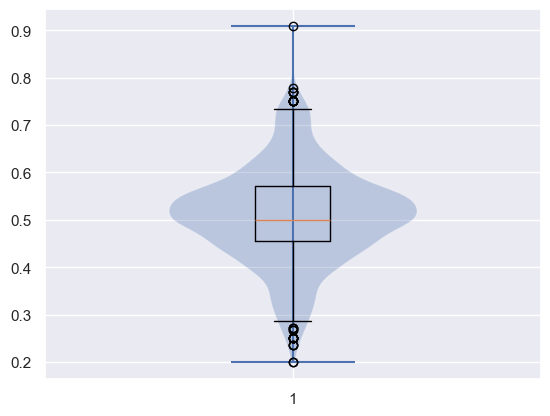

In [9]:
plt.violinplot(stopword_pct_arr)
plt.boxplot(stopword_pct_arr)
plt.show()

## Dataset

In [10]:
input_sequence = []

for datapoint in data:
    token_list = tokenizer.texts_to_sequences([datapoint])[0]
                                                              
    input_sequence.append(token_list)

print(f'Total number of quotes: {len(input_sequence)}')

Total number of quotes: 1000


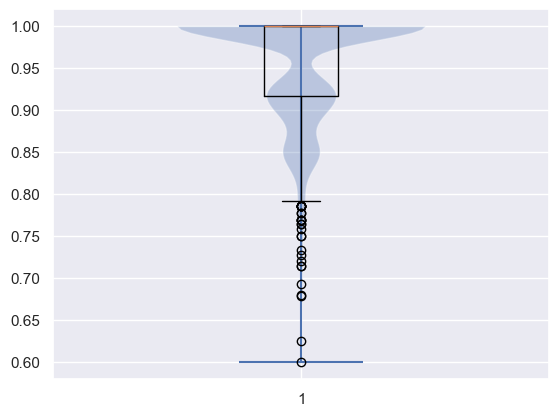

In [11]:
#how many unique words are there usually in sentences?
unique_ratios = []
for sentence in input_sequence:
    unique_ratios.append(len(np.unique(sentence))/len(sentence))
plt.violinplot(unique_ratios)
plt.boxplot(unique_ratios)
plt.show()

In [12]:
max_sequence_len = max([len(x) for x in input_sequence])
max_sequence_len

35

In [13]:
results=[]
for i in range(1, max_sequence_len):
    temp=[]
    for arr in input_sequence:
        for ii in range(len(arr) - i):
            temp.append(arr[ii:ii + i+1])
            
    # print(np.array(temp).shape)
    results.append(temp)

print(f'Total number of input-output pairs is: {list(map(len,results))}')
print(f'Len of input-output pairs is: {sum(list(map(len,results)))}')



Total number of input-output pairs is: [10886, 9886, 8886, 7886, 6886, 5886, 4886, 3893, 2916, 2044, 1359, 878, 554, 376, 293, 240, 200, 169, 147, 129, 111, 94, 77, 61, 49, 39, 29, 20, 15, 12, 9, 6, 3, 1]
Len of input-output pairs is: 68926


In [14]:
# vocab = {v:k for k,v in tokenizer.word_index.items()}
# total_n = 5
# counted_vocab = {}
# for n in range(total_n):
#     word_idx = {}
#     ngram = results[n]
#     for gram in ngram:
#         gram_txt = []
#         if word_idx.get(tuple(gram)) is None:
#             for text in gram:
#                 gram_txt.append(vocab[text])
#             word_idx[tuple(gram)] = [' '.join(gram_txt),1]
#         else:
#             word_idx[tuple(gram)][1] += 1
#     word_idx = sorted(word_idx.items(), key= lambda x: x[1][1], reverse=True)
#     counted_vocab[n] = word_idx

In [15]:
# fig = plt.figure(figsize=(24,5))
# bigram_word_idx = counted_vocab[0]
# asdf = np.array(list(map(lambda x: x[1],bigram_word_idx))[:10])

# plt.bar(asdf[:,0],asdf[:,1].astype(int))
# plt.title(f'2-gram top 10')

In [16]:
# fig = plt.figure(figsize=(24,5))
# gram_word_idx = counted_vocab[1]
# asdf = np.array(list(map(lambda x: x[1],gram_word_idx))[:10])

# plt.bar(asdf[:,0],asdf[:,1].astype(int))
# plt.title(f'3-gram top 10')

In [17]:
# fig = plt.figure(figsize=(24,5))
# gram_word_idx = counted_vocab[2]
# asdf = np.array(list(map(lambda x: x[1],gram_word_idx))[:10])

# plt.bar(asdf[:,0],asdf[:,1].astype(int))
# plt.title(f'4-gram top 10')

In [18]:
# fig = plt.figure(figsize=(24,5))
# gram_word_idx = counted_vocab[3]
# asdf = np.array(list(map(lambda x: x[1],gram_word_idx))[:10])

# plt.bar(asdf[:,0],asdf[:,1].astype(int))
# plt.title(f'5-gram top 10')

In [19]:
max_sequence_len = len(arr)
pairs = results[0]
print(pairs)
for iii in range(1,max_sequence_len):
    pairs += results[iii]

pairs

[[19, 1], [1, 53], [53, 2], [2, 13], [13, 87], [87, 408], [408, 5], [5, 181], [181, 521], [521, 12], [12, 110], [110, 3], [3, 43], [43, 22], [22, 50], [19, 158], [158, 31], [31, 24], [24, 1], [1, 409], [409, 522], [522, 12], [12, 3], [3, 410], [410, 719], [19, 1], [1, 111], [111, 2], [2, 33], [33, 4], [4, 9], [9, 11], [11, 17], [17, 20], [20, 3], [3, 41], [19, 34], [34, 8], [8, 11], [11, 159], [159, 1], [1, 38], [38, 12], [12, 73], [73, 1], [1, 43], [43, 411], [411, 28], [28, 523], [523, 5], [5, 328], [19, 1], [1, 48], [48, 8], [8, 11], [11, 264], [264, 12], [12, 1], [1, 720], [720, 2], [2, 3], [3, 35], [19, 3], [3, 524], [524, 8], [8, 11], [11, 7], [7, 1], [1, 721], [721, 2], [2, 3], [3, 41], [41, 98], [98, 1], [1, 131], [19, 1], [1, 230], [230, 117], [117, 8], [8, 11], [11, 7], [7, 1], [1, 525], [525, 411], [411, 16], [16, 329], [329, 722], [19, 3], [3, 412], [412, 8], [8, 31], [31, 67], [67, 1], [1, 182], [182, 12], [12, 330], [330, 3], [3, 65], [65, 61], [19, 44], [44, 4], [4, 123]

[[19, 1],
 [1, 53],
 [53, 2],
 [2, 13],
 [13, 87],
 [87, 408],
 [408, 5],
 [5, 181],
 [181, 521],
 [521, 12],
 [12, 110],
 [110, 3],
 [3, 43],
 [43, 22],
 [22, 50],
 [19, 158],
 [158, 31],
 [31, 24],
 [24, 1],
 [1, 409],
 [409, 522],
 [522, 12],
 [12, 3],
 [3, 410],
 [410, 719],
 [19, 1],
 [1, 111],
 [111, 2],
 [2, 33],
 [33, 4],
 [4, 9],
 [9, 11],
 [11, 17],
 [17, 20],
 [20, 3],
 [3, 41],
 [19, 34],
 [34, 8],
 [8, 11],
 [11, 159],
 [159, 1],
 [1, 38],
 [38, 12],
 [12, 73],
 [73, 1],
 [1, 43],
 [43, 411],
 [411, 28],
 [28, 523],
 [523, 5],
 [5, 328],
 [19, 1],
 [1, 48],
 [48, 8],
 [8, 11],
 [11, 264],
 [264, 12],
 [12, 1],
 [1, 720],
 [720, 2],
 [2, 3],
 [3, 35],
 [19, 3],
 [3, 524],
 [524, 8],
 [8, 11],
 [11, 7],
 [7, 1],
 [1, 721],
 [721, 2],
 [2, 3],
 [3, 41],
 [41, 98],
 [98, 1],
 [1, 131],
 [19, 1],
 [1, 230],
 [230, 117],
 [117, 8],
 [8, 11],
 [11, 7],
 [7, 1],
 [1, 525],
 [525, 411],
 [411, 16],
 [16, 329],
 [329, 722],
 [19, 3],
 [3, 412],
 [412, 8],
 [8, 31],
 [31, 67],
 [67, 

In [20]:
io_pairs = np.array(pad_sequences(pairs, maxlen=max_sequence_len, padding='pre'))
io_pairs

array([[  0,   0,   0, ...,   0,  19,   1],
       [  0,   0,   0, ...,   0,   1,  53],
       [  0,   0,   0, ...,   0,  53,   2],
       ...,
       [  3, 477,  59, ..., 287,  16, 632],
       [477,  59,   5, ...,  16, 632,   3],
       [ 59,   5, 929, ..., 632,   3,  54]])

In [21]:
X = io_pairs[:,:-1]
y = io_pairs[:,-1]
print(X)
print(y)

[[  0   0   0 ...   0   0  19]
 [  0   0   0 ...   0   0   1]
 [  0   0   0 ...   0   0  53]
 ...
 [  3 477  59 ... 113 287  16]
 [477  59   5 ... 287  16 632]
 [ 59   5 929 ...  16 632   3]]
[  1  53   2 ... 632   3  54]


In [22]:
y = to_categorical(y, num_classes=vocab_size)
y

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=True, random_state=seed)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size=0.5, shuffle=True, random_state=seed)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((54945, 22),
 (6868, 22),
 (6869, 22),
 (54945, 1199),
 (6868, 1199),
 (6869, 1199))

# Model Building

In [24]:
# Hyperparameters
lr = 1e-3
batch_size = 128
units = 256
nodes = 512
embeddings = 64 #round(np.sqrt(vocab_size))
dropout = 0.4
epochs= 40

# Loss and Optim
loss = lambda : CategoricalCrossentropy()
optimizer = lambda: Adam(learning_rate=lr)

# Filepath
cp_fp ='./model_checkpoints/train/'

In [25]:
#Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reducelr = ReduceLROnPlateau(monitor='val_loss',patience=5)
modelcp = lambda fp: ModelCheckpoint(filepath=fp, monitor='val_loss', save_best_only=True, save_weights_only=True, save_format='h5')

In [26]:
def train_model(model, model_name, X_train=X_train, y_train=y_train, validation_data=(X_val,y_val),
                shuffle=True, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, reducelr]):
    callbacks.append(modelcp(f'{cp_fp}best/{model_name}.h5'))

    history = model.fit(X_train,y_train, validation_data=validation_data, shuffle=shuffle, epochs=epochs,
                       batch_size=batch_size, callbacks=callbacks)
    model.save_weights(f'{cp_fp}last/{model_name}.h5', save_format='h5', overwrite=True)

    history= pd.DataFrame(history.history, columns=history.history.keys())
    return history

In [27]:
def show_plots(df, ignore=2):
    feats = (len(df.columns)-1)//2
    for i in range(feats):
        df.iloc[ignore:,[i,i+feats]].plot()

## Architectures

In [56]:
def get_GRU(units, dropout, embeddings, loss, optimizer, summary=False):
    model = Sequential([
        Embedding(vocab_size, embeddings, input_length=max_sequence_len-1),
        GRU(units),
        Dropout(dropout),
        BatchNormalization(),
        Dense(vocab_size, activation='softmax')
    ])
    
    #Metrics
    def perplexity(y_true, y_pred):
        return tf.exp(loss(y_true,y_pred))

    def simplicity(y_true,y_pred):
        '''
        measures the percentage of how sure the model is of the next word out of the total vocab_size
        '''
        return (vocab_size-perplexity(y_true, y_pred))/vocab_size

    model.compile(optimizer=optimizer, loss=loss, metrics=[perplexity, simplicity])
    if summary:
        model.summary()

    return model

In [57]:
def get_GRUv2(units, dropout, embeddings, loss, optimizer, summary=False):
    model = Sequential([
        Embedding(vocab_size, embeddings, input_length=max_sequence_len-1),
        Bidirectional(GRU(units)),
        Dropout(dropout),
        BatchNormalization(),
        Dense(vocab_size, activation='softmax')
    ])

    #Metrics
    def perplexity(y_true, y_pred):
        return tf.exp(loss(y_true,y_pred))

    def simplicity(y_true,y_pred):
        '''
        measures the percentage of how sure the model is of the next word out of the total vocab_size
        '''
        return (vocab_size-perplexity(y_true, y_pred))/vocab_size

    model.compile(optimizer=optimizer, loss=loss, metrics=[perplexity, simplicity])
    if summary:
        model.summary()

    return model

In [58]:
def get_GRU_MLP(units, nodes, dropout, embeddings, loss, optimizer, summary=False):
    model = Sequential([
        Embedding(vocab_size, embeddings, input_length=max_sequence_len-1),
        Bidirectional(GRU(units)),
        Dropout(dropout),
        BatchNormalization(),
        Dense(nodes, activation='relu'),
        Dense(nodes, activation='relu'),
        Dense(vocab_size, activation='softmax')
    ])

    #Metrics
    def perplexity(y_true, y_pred):
        return tf.exp(loss(y_true,y_pred))

    def simplicity(y_true,y_pred):
        '''
        measures the percentage of how sure the model is of the next word out of the total vocab_size
        '''
        return (vocab_size-perplexity(y_true, y_pred))/vocab_size

    model.compile(optimizer=optimizer, loss=loss, metrics=[perplexity, simplicity])
    if summary:
        model.summary()

    return model

In [59]:
def get_GRU_MLPv2(units, nodes, dropout, embeddings, loss, optimizer, summary=False):
    model = Sequential([
        Embedding(vocab_size, embeddings, input_length=max_sequence_len-1),
        Bidirectional(GRU(units)),
        Dropout(dropout),
        BatchNormalization(),
        Dense(nodes//2, activation='relu'),
        Dropout(dropout),
        BatchNormalization(),
        Dense(nodes, activation='relu'),
        Dropout(dropout),
        BatchNormalization(),
        Dense(vocab_size, activation='softmax')
    ])

    #Metrics
    def perplexity(y_true, y_pred):
        return tf.exp(loss(y_true,y_pred))

    def simplicity(y_true,y_pred):
        '''
        measures the percentage of how sure the model is of the next word out of the total vocab_size
        '''
        return (vocab_size-perplexity(y_true, y_pred))/vocab_size

    model.compile(optimizer=optimizer, loss=loss, metrics=[perplexity, simplicity])
    if summary:
        model.summary()

    return model

In [60]:
def get_GRU_MLPv3(units, nodes, dropout, embeddings, loss, optimizer, summary=False):
    model = Sequential([
        Embedding(vocab_size, embeddings, input_length=max_sequence_len-1),
        BatchNormalization(),
        GRU(units),
        Dropout(dropout),
        BatchNormalization(),
        Dense(nodes//2, activation='relu'),
        Dropout(dropout),
        BatchNormalization(),
        Dense(nodes, activation='relu'),
        Dropout(dropout),
        BatchNormalization(),
        Dense(vocab_size, activation='softmax')
    ])

    #Metrics
    def perplexity(y_true, y_pred):
        return tf.exp(loss(y_true,y_pred))

    def simplicity(y_true,y_pred):
        '''
        measures the percentage of how sure the model is of the next word out of the total vocab_size
        '''
        return (vocab_size-perplexity(y_true, y_pred))/vocab_size

    model.compile(optimizer=optimizer, loss=loss, metrics=[perplexity, simplicity])
    if summary:
        model.summary()

    return model

In [61]:
def get_GRU_MLPv4(units, nodes, dropout, embeddings, loss, optimizer, summary=False):
    model = Sequential([
        Embedding(vocab_size, embeddings, input_length=max_sequence_len-1),
        Bidirectional(GRU(units, dropout=dropout)),
        BatchNormalization(),
        Dense(nodes//2, activation='relu'),
        Dropout(dropout),
        BatchNormalization(),
        Dense(nodes, activation='relu'),
        Dropout(dropout),
        BatchNormalization(),
        Dense(vocab_size, activation='softmax')
    ])
    #Metrics
    def perplexity(y_true, y_pred):
        return tf.exp(loss(y_true,y_pred))

    def simplicity(y_true,y_pred):
        '''
        measures the percentage of how sure the model is of the next word out of the total vocab_size
        '''
        return (vocab_size-perplexity(y_true, y_pred))/vocab_size

    model.compile(optimizer=optimizer, loss=loss, metrics=[perplexity, simplicity])
    if summary:
        model.summary()

    return model

In [62]:
def get_GRU_MLPv5(units, nodes, dropout, embeddings, loss, optimizer, summary=False):
    model = Sequential([
        Embedding(vocab_size, embeddings, input_length=max_sequence_len-1),
        Bidirectional(GRU(units, dropout=dropout)),
        Dropout(dropout),
        BatchNormalization(),
        Dense(nodes//2, activation='relu'),
        Dropout(dropout),
        BatchNormalization(),
        Dense(nodes, activation='relu'),
        Dropout(dropout),
        BatchNormalization(),
        Dense(vocab_size, activation='softmax')
    ])

    #Metrics
    def perplexity(y_true, y_pred):
        return tf.exp(loss(y_true,y_pred))

    def simplicity(y_true,y_pred):
        '''
        measures the percentage of how sure the model is of the next word out of the total vocab_size
        '''
        return (vocab_size-perplexity(y_true, y_pred))/vocab_size

    model.compile(optimizer=optimizer, loss=loss, metrics=[perplexity, simplicity])
    if summary:
        model.summary()

    return model

## GRUV1

In [684]:
gru = get_GRU(units,dropout,embeddings,loss(),optimizer(),summary=True)
history_gru = train_model(gru, f'gru-{units}-{None}-{dropout}-{embeddings}')
history_gru

Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_64 (Embedding)    (None, 22, 64)            76736     
                                                                 
 gru_64 (GRU)                (None, 256)               247296    
                                                                 
 dropout_110 (Dropout)       (None, 256)               0         
                                                                 
 batch_normalization_136 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 dense_186 (Dense)           (None, 1199)              308143    
                                                                 
Total params: 633,199
Trainable params: 632,687
Non-trainable params: 512
_____________________________________________

,loss,perplexity,simplicity,val_loss,val_perplexity,val_simplicity,lr
0,3.639201,129.253708,0.892199,3.310519,27.626919,0.976958,0.00100
1,1.738177,5.897512,0.995081,1.337512,3.842954,0.996795,0.00100
2,1.283043,3.657392,0.996949,1.130609,3.126667,0.997392,0.00100
3,1.122423,3.108152,0.997407,1.033094,2.834477,0.997636,0.00100
4,1.039283,2.859132,0.997615,0.982007,2.694951,0.997752,0.00100
5,0.995080,2.736656,0.997717,0.951129,2.610293,0.997823,0.00100
6,0.964154,2.657332,0.997784,0.932252,2.564277,0.997861,0.00100
7,0.940636,2.591396,0.997839,0.921806,2.536618,0.997884,0.00100
8,0.918412,2.535491,0.997885,0.920290,2.530668,0.997889,0.00100
9,0.910514,2.510575,0.997906,0.909969,2.508208,0.997908,0.00100


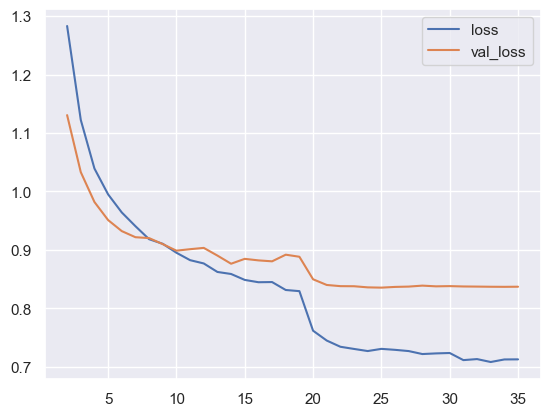

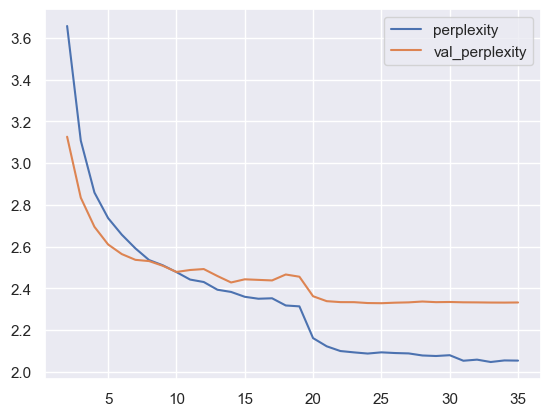

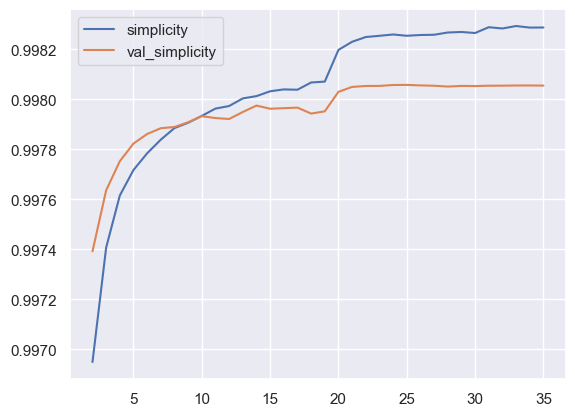

In [685]:
show_plots(history_gru)

## GRUV2

In [54]:
gruv2 = get_GRUv2(units,dropout,embeddings,loss(),optimizer(),summary=True)
history_gruv2 = train_model(gruv2, f'gruv2-{units}-{None}-{dropout}-{embeddings}')
history_gruv2

Epoch 1/40
430/430 [==============================] - 13s 21ms/step - loss: 3.4685 - perplexity: 114.9257 - val_loss: 3.0835 - val_perplexity: 22.0294 - lr: 0.0010
Epoch 2/40
430/430 [==============================] - 9s 20ms/step - loss: 1.5902 - perplexity: 5.0511 - val_loss: 1.2728 - val_perplexity: 3.5981 - lr: 0.0010
Epoch 3/40
430/430 [==============================] - 10s 23ms/step - loss: 1.1866 - perplexity: 3.3149 - val_loss: 1.0876 - val_perplexity: 2.9942 - lr: 0.0010
Epoch 4/40
430/430 [==============================] - 10s 24ms/step - loss: 1.0459 - perplexity: 2.8788 - val_loss: 1.0250 - val_perplexity: 2.8096 - lr: 0.0010
Epoch 5/40
430/430 [==============================] - 10s 24ms/step - loss: 0.9856 - perplexity: 2.7087 - val_loss: 0.9877 - val_perplexity: 2.7172 - lr: 0.0010
Epoch 6/40
430/430 [==============================] - 11s 26ms/step - loss: 0.9448 - perplexity: 2.6058 - val_loss: 0.9475 - val_perplexity: 2.6044 - lr: 0.0010
Epoch 7/40
430/430 [============

,loss,perplexity,val_loss,val_perplexity,lr
0,3.468495,114.925652,3.083484,22.029356,0.00100
1,1.590197,5.051073,1.272762,3.598050,0.00100
2,1.186611,3.314873,1.087585,2.994225,0.00100
3,1.045916,2.878834,1.025001,2.809574,0.00100
4,0.985643,2.708741,0.987686,2.717209,0.00100
5,0.944845,2.605792,0.947535,2.604385,0.00100
6,0.922476,2.545906,0.925214,2.547072,0.00100
7,0.900785,2.485584,0.937074,2.578958,0.00100
8,0.885193,2.448955,0.929159,2.560819,0.00100
9,0.875056,2.425023,0.914599,2.520683,0.00100


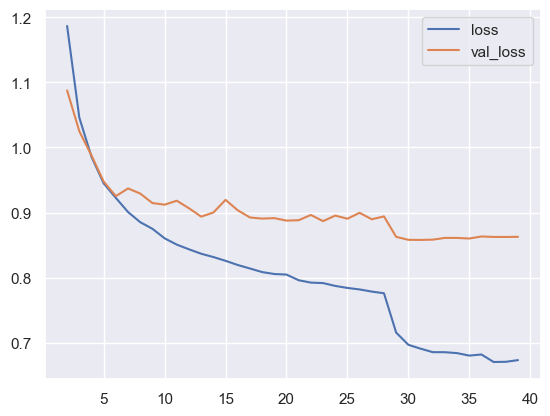

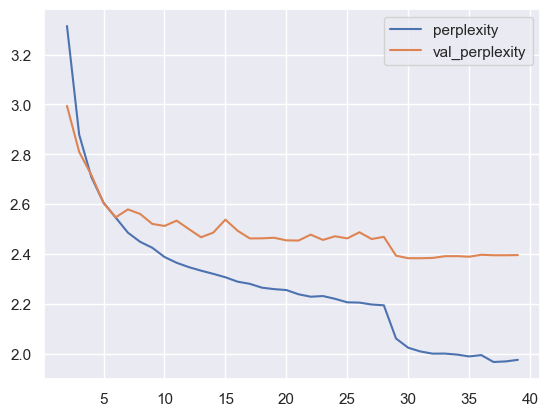

In [55]:
show_plots(history_gruv2)

## GRU_MLP

In [57]:
gru_mlp = get_GRU_MLP(units, nodes, dropout,embeddings,loss(),optimizer(),summary=True)
history_gru_mlp = train_model(gru_mlp, f'gru_mlp-{units}-{nodes}-{dropout}-{embeddings}')
history_gru_mlp

Epoch 1/40
430/430 [==============================] - 14s 23ms/step - loss: 3.4066 - perplexity: 64.7168 - val_loss: 3.4046 - val_perplexity: 30.2474 - lr: 0.0010
Epoch 2/40
430/430 [==============================] - 9s 22ms/step - loss: 1.6125 - perplexity: 5.1640 - val_loss: 1.3348 - val_perplexity: 3.8462 - lr: 0.0010
Epoch 3/40
430/430 [==============================] - 9s 21ms/step - loss: 1.1962 - perplexity: 3.3465 - val_loss: 1.0889 - val_perplexity: 3.0004 - lr: 0.0010
Epoch 4/40
430/430 [==============================] - 9s 20ms/step - loss: 1.0469 - perplexity: 2.8795 - val_loss: 1.0834 - val_perplexity: 2.9831 - lr: 0.0010
Epoch 5/40
430/430 [==============================] - 8s 19ms/step - loss: 0.9648 - perplexity: 2.6494 - val_loss: 1.0100 - val_perplexity: 2.7735 - lr: 0.0010
Epoch 6/40
430/430 [==============================] - 9s 20ms/step - loss: 0.9234 - perplexity: 2.5501 - val_loss: 0.9614 - val_perplexity: 2.6402 - lr: 0.0010
Epoch 7/40
430/430 [=================

,loss,perplexity,val_loss,val_perplexity,lr
0,3.406559,64.716827,3.404588,30.247446,0.00100
1,1.612497,5.163961,1.334783,3.846180,0.00100
2,1.196157,3.346510,1.088943,3.000366,0.00100
3,1.046859,2.879548,1.083440,2.983130,0.00100
4,0.964753,2.649429,1.009964,2.773461,0.00100
5,0.923351,2.550139,0.961353,2.640153,0.00100
6,0.890089,2.459012,0.950141,2.617479,0.00100
7,0.869058,2.405885,0.920108,2.537545,0.00100
8,0.846606,2.351935,0.924207,2.551129,0.00100
9,0.835979,2.326523,0.919414,2.535086,0.00100


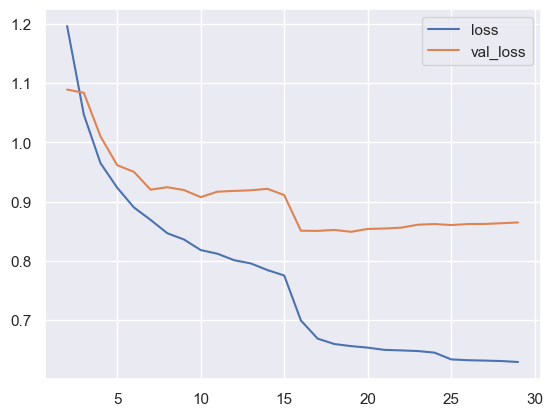

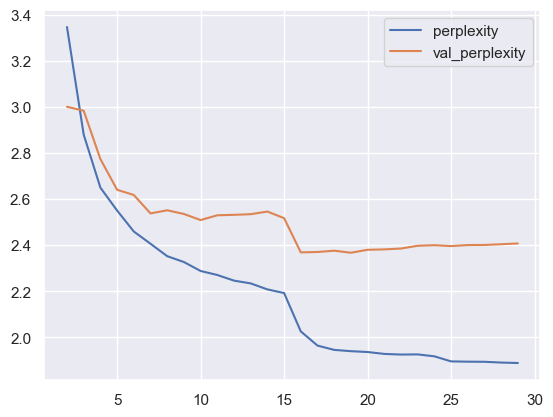

In [58]:
show_plots(history_gru_mlp)

## GRU_MLPV2

In [83]:
gru_mlpv2 = get_GRU_MLPv2(units, nodes, dropout,embeddings,loss(),optimizer(),summary=True)
history_gru_mlpv2 = train_model(gru_mlpv2, f'gru_mlpv2-{units}-{nodes}-{dropout}-{embeddings}')
history_gru_mlpv2

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_43 (Embedding)    (None, 34, 64)            76736     
                                                                 
 bidirectional_29 (Bidirecti  (None, 512)              494592    
 onal)                                                           
                                                                 
 dropout_57 (Dropout)        (None, 512)               0         
                                                                 
 batch_normalization_57 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_83 (Dense)            (None, 256)               131328    
                                                                 
 dropout_58 (Dropout)        (None, 256)             

,loss,perplexity,val_loss,val_perplexity,lr
0,4.345744,215.554016,3.991036,55.130817,0.0010
1,2.597200,14.023919,1.896253,6.741610,0.0010
2,2.030790,7.781982,1.493186,4.496592,0.0010
3,1.748665,5.839599,1.309903,3.744804,0.0010
4,1.570850,4.878321,1.213157,3.398601,0.0010
5,1.459735,4.360263,1.121303,3.098321,0.0010
6,1.380429,4.027570,1.087903,2.994034,0.0010
7,1.321368,3.796538,1.047187,2.878705,0.0010
8,1.264622,3.591377,1.025303,2.818257,0.0010
9,1.226677,3.463364,0.990988,2.719182,0.0010


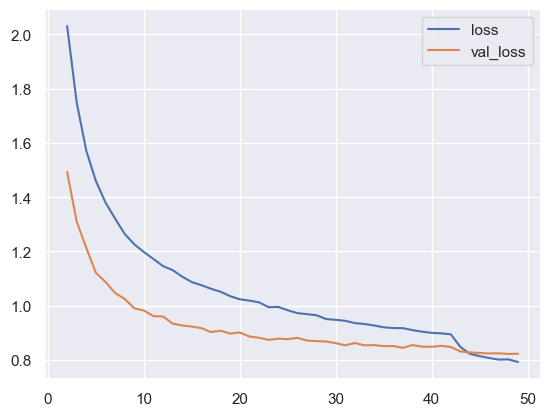

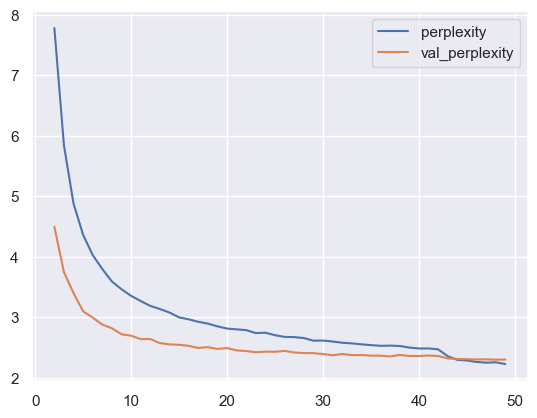

In [84]:
show_plots(history_gru_mlpv2)

## GRU_MLPV3


In [5]:
try:
    gru_mlpv3 = get_GRU_MLPv3(units, nodes, dropout,embeddings,loss(),optimizer(),summary=True)
    history_gru_mlpv3 = train_model(gru_mlpv3, f'gru_mlpv3-{units}-{nodes}-{dropout}-{embeddings}')
    display(history_gru_mlpv3)
    success()
except:
    failure()

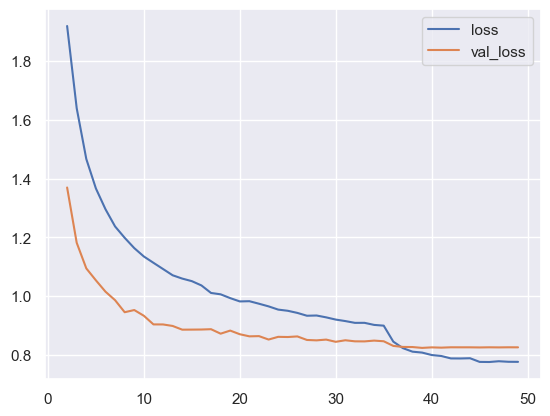

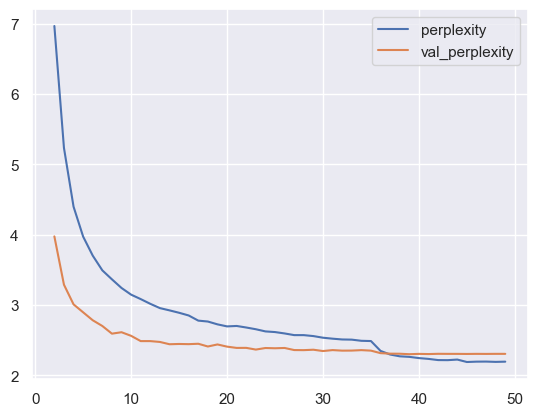

In [116]:
show_plots(history_gru_mlpv3)

## GRU_MLPV4

In [150]:
try:
    gru_mlpv4 = get_GRU_MLPv4(units, nodes, dropout,embeddings,loss(),optimizer(),summary=True)
    history_gru_mlpv4 = train_model(gru_mlpv4, f'gru_mlpv4-{units}-{nodes}-{dropout}-{embeddings}')
    display(history_gru_mlpv4)
    success()
except:
    failure()
    pass

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 22, 64)            76736     
                                                                 
 bidirectional_19 (Bidirecti  (None, 512)              494592    
 onal)                                                           
                                                                 
 batch_normalization_55 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_61 (Dense)            (None, 512)               262656    
                                                                 
 dropout_44 (Dropout)        (None, 512)               0         
                                                                 
 batch_normalization_56 (Bat  (None, 512)            

,loss,perplexity,val_loss,val_perplexity,lr
0,3.938858,128.651596,3.968096,53.643963,0.00100
1,2.444016,11.892211,5.846108,357.208221,0.00100
2,1.912263,6.902761,3.785493,45.311745,0.00100
3,1.635153,5.229281,3.363105,29.920420,0.00100
4,1.477908,4.452292,2.318057,10.403762,0.00100
...,...,...,...,...,...
70,0.726832,2.085898,0.810064,2.270832,0.00001
71,0.725885,2.082529,0.810822,2.272658,0.00001
72,0.726763,2.082248,0.810652,2.272264,0.00001
73,0.727361,2.086608,0.810964,2.273019,0.00001


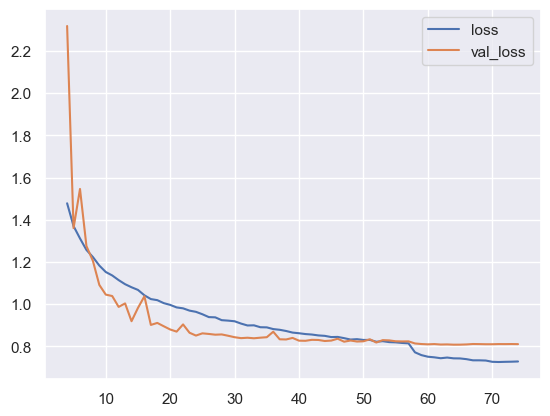

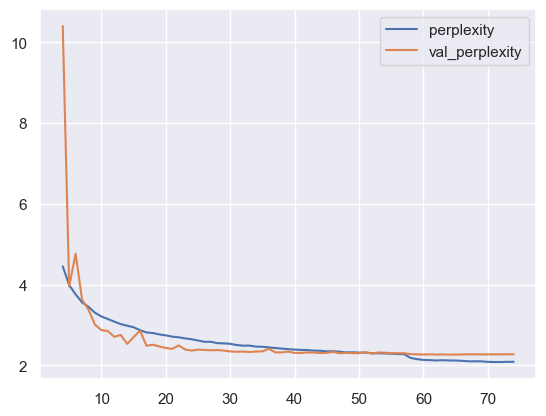

In [151]:
show_plots(history_gru_mlpv4, 4)

## GRU_MLPV5

In [160]:
try:
    gru_mlpv5 = get_GRU_MLPv5(units, nodes, dropout,embeddings,loss(),optimizer(),summary=True)
    history_gru_mlpv5 = train_model(gru_mlpv5, f'gru_mlpv5-{units}-{nodes}-{dropout}-{embeddings}')
    display(history_gru_mlpv5)
    # success()
except:
    # failure()
    pass

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_44 (Embedding)    (None, 34, 128)           153472    
                                                                 
 bidirectional_33 (Bidirecti  (None, 1024)             1972224   
 onal)                                                           
                                                                 
 dropout_76 (Dropout)        (None, 1024)              0         
                                                                 
 batch_normalization_94 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dense_105 (Dense)           (None, 256)               262400    
                                                                 
 dropout_77 (Dropout)        (None, 256)             

,loss,perplexity,val_loss,val_perplexity,lr
0,4.440384,206.703033,3.796429,45.392246,0.00100
1,2.872962,18.413353,2.079893,8.101659,0.00100
2,2.324465,10.438706,1.655853,5.291566,0.00100
3,2.016336,7.647664,1.448237,4.293014,0.00100
4,1.829824,6.338079,1.321984,3.783407,0.00100
...,...,...,...,...,...
68,0.818866,2.286913,0.822707,2.296466,0.00001
69,0.821949,2.295904,0.822612,2.296278,0.00001
70,0.820176,2.291428,0.822427,2.295812,0.00001
71,0.820473,2.290241,0.821929,2.294685,0.00001


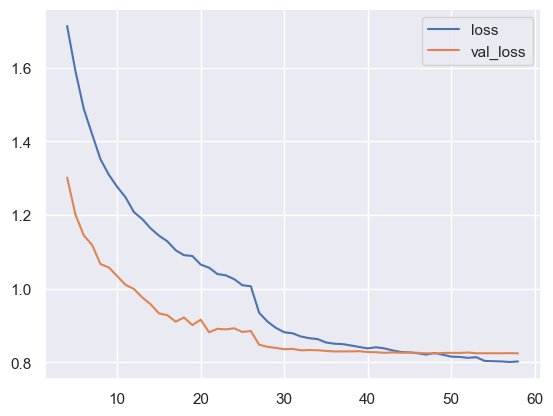

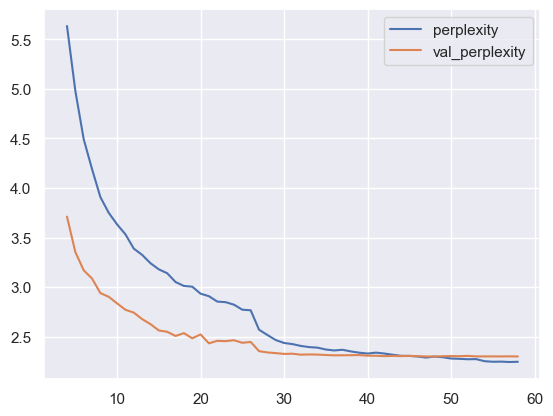

In [138]:
show_plots(history_gru_mlpv5, 4)

# Model Testing

## Current models in runtime

In [50]:
try:
    gru.evaluate(X_test,y_test, batch_size=batch_size)
except:
    print("Model not found")

54/54 [==============================] - 1s 9ms/step - loss: 0.8808 - perplexity: 2.4401


In [60]:
try:
    gruv2.evaluate(X_test,y_test, batch_size=batch_size)
except:
    print("Model not found")

54/54 [==============================] - 1s 10ms/step - loss: 0.8830 - perplexity: 2.4460


In [61]:
try:
    gru_mlp.evaluate(X_test,y_test, batch_size=batch_size)
except:
    print("Model not found")

54/54 [==============================] - 0s 8ms/step - loss: 0.8917 - perplexity: 2.4704


In [120]:
try:
    gru_mlpv2.evaluate(X_test,y_test, batch_size=batch_size)
except:
    print("Model not found")

54/54 [==============================] - 1s 10ms/step - loss: 0.8378 - perplexity: 2.3345


In [121]:
try:
    gru_mlpv3.evaluate(X_test,y_test, batch_size=batch_size)
except:
    print("Model not found")

54/54 [==============================] - 0s 9ms/step - loss: 0.8489 - perplexity: 2.3647


In [152]:
try:
    gru_mlpv4.evaluate(X_test,y_test, batch_size=batch_size)
except:
    print("Model not found")

54/54 [==============================] - 1s 10ms/step - loss: 0.8289 - perplexity: 2.3173


In [162]:
try:
    gru_mlpv5.evaluate(X_test,y_test, batch_size=batch_size)
except:
    print("Model not found")

54/54 [==============================] - 1s 10ms/step - loss: 0.8364 - perplexity: 2.3357


## Saved Models

In [63]:
def get_results(model, test_ds, best_fp,last_fp=None, checkpoint=None):
    results = pd.DataFrame({
        'loss': [],
        'perplexity': [],
        'simplicity':[]
    })

    best_model = model()
    best_model.load_weights(best_fp)
    best_metrics  = best_model.evaluate(*test_ds, verbose=1)
    results = pd.concat((results, pd.DataFrame([best_metrics], columns=results.columns, index=[checkpoint if checkpoint is not None else 'best' ])), axis=0)

    if last_fp is not None:
        last_model = model()
        last_model.load_weights(last_fp)
        last_metrics = last_model.evaluate(*test_ds, verbose=1)
        results = pd.concat((results, pd.DataFrame([last_metrics], columns=results.columns, index=['last'])), axis=0)

    return results

In [64]:
summary = False
flag = 0


for cp_type in ['best','last']:
    with os.scandir(f'{cp_fp}{cp_type}') as dir:
        checkpoint_dict = {}
        for entry in dir:
            checkpoint = entry.name[:-3].split('-')
            modelname, cp_units, cp_nodes, cp_dropout, cp_embed = checkpoint
            cp_units, cp_dropout, cp_embed = int(cp_units), float(cp_dropout), int(cp_embed)
            cp_nodes = int(cp_nodes) if cp_nodes != 'None' else None
            
            model_dict={'gru':lambda:get_GRU(cp_units, cp_dropout, cp_embed, loss(), optimizer(), summary=summary),
            'gruv2':lambda:get_GRUv2(cp_units, cp_dropout, cp_embed, loss(), optimizer(), summary=summary),
            'gru_mlp':lambda:get_GRU_MLP(cp_units, cp_nodes, cp_dropout, cp_embed, loss(), optimizer(), summary=summary),
            'gru_mlpv2':lambda:get_GRU_MLPv2(cp_units, cp_nodes, cp_dropout, cp_embed, loss(), optimizer(), summary=summary),
            'gru_mlpv3':lambda:get_GRU_MLPv3(cp_units, cp_nodes, cp_dropout, cp_embed, loss(), optimizer(), summary=summary),
            'gru_mlpv4':lambda:get_GRU_MLPv4(cp_units, cp_nodes, cp_dropout, cp_embed, loss(), optimizer(), summary=summary),
            'gru_mlpv5':lambda:get_GRU_MLPv5(cp_units, cp_nodes, cp_dropout, cp_embed, loss(), optimizer(), summary=summary),
            }
            model = model_dict.get(modelname)
            test_ds = (X_test, y_test)
            
            if model is None:
                continue

            test_fp = f'./model_checkpoints/train/{cp_type}/{entry.name}'
            entry_label = f'{cp_type}_{entry.name}'
            
            if not flag:
                flag = 1
                print(modelname, entry.name, test_fp)
                compiled_results = get_results(model, test_ds, test_fp, checkpoint=entry_label)
            else:
                print(modelname, entry.name, test_fp)
                compiled_results = pd.concat((compiled_results, get_results(model, test_ds, test_fp, checkpoint=entry_label)))
           
    
display(compiled_results.sort_values(by='loss'))
success()

gru gru-256-None-0.4-64.h5 ./model_checkpoints/train/best/gru-256-None-0.4-64.h5
215/215 [==============================] - 2s 5ms/step - loss: 0.8479 - perplexity: 2.4488 - simplicity: 0.9980
gruv2 gruv2-256-None-0.4-64.h5 ./model_checkpoints/train/best/gruv2-256-None-0.4-64.h5
215/215 [==============================] - 3s 6ms/step - loss: 0.8577 - perplexity: 2.4813 - simplicity: 0.9979
gru_mlp gru_mlp-256-512-0.3-64.h5 ./model_checkpoints/train/best/gru_mlp-256-512-0.3-64.h5
215/215 [==============================] - 3s 6ms/step - loss: 0.8747 - perplexity: 2.5430 - simplicity: 0.9979
gru_mlp gru_mlp-256-512-0.4-64.h5 ./model_checkpoints/train/best/gru_mlp-256-512-0.4-64.h5
215/215 [==============================] - 3s 6ms/step - loss: 0.8903 - perplexity: 2.6335 - simplicity: 0.9978
gru_mlpv2 gru_mlpv2-256-512-0.4-64.h5 ./model_checkpoints/train/best/gru_mlpv2-256-512-0.4-64.h5
215/215 [==============================] - 3s 6ms/step - loss: 0.8371 - perplexity: 2.4311 - simplicity: 

,loss,perplexity,simplicity
best_gru_mlpv4-256-512-0.4-64.h5,0.826936,2.402956,0.997996
best_gru_mlpv4-256-1024-0.4-64.h5,0.827257,2.406600,0.997993
last_gru_mlpv4-256-512-0.4-64.h5,0.827924,2.405796,0.997994
last_gru_mlpv4-256-1024-0.4-64.h5,0.828907,2.414272,0.997986
best_gru_mlpv4-256-512-0.4-128.h5,0.829819,2.411918,0.997988
best_gru_mlpv4-512-512-0.4-128.h5,0.831045,2.413691,0.997987
last_gru_mlpv4-256-512-0.4-128.h5,0.831640,2.417552,0.997984
last_gru_mlpv4-512-512-0.4-128.h5,0.832474,2.418688,0.997983
last_gru_mlpv4-256-512-0.4-32.h5,0.835856,2.419036,0.997982
best_gru_mlpv4-256-512-0.4-32.h5,0.835856,2.419036,0.997982


# Model Prediction

## Evalulation metrics

### Stopword Realism

In [34]:
def sw_realism(text):
        '''
        measures how realistic the sentence is based on how close
        the ratio of stopwords to nonstopwords are in the predicted sentence

        Uses the corpus as a baseline for what is realistic
        '''

        text_len = len(text.split())
        num_sw = count_stopwords(text)
        text_sw_pct = num_sw/text_len
        return text_sw_pct/stopwords_percentage if stopwords_percentage>text_sw_pct else stopwords_percentage/text_sw_pct

In [35]:
sw_realism('There are decades where nothing happens, and there are weeks where decades happen')

0.8283037681795559

### Word Embedding Similarity

In [36]:
def get_word_embed(embeddings,summary=False):
  word_embed = Sequential([
    Embedding(vocab_size, embeddings, name="embedding"),
    GlobalAveragePooling1D(),
    Dense(32, activation='relu'),
    Dense(1)
  ])

  word_embed.compile(loss=BinaryCrossentropy(), optimizer=Adam(learning_rate=1e-6), metrics=['accuracy'])
  if summary:
    word_embed.summary()

  return word_embed

In [37]:
if not os.path.exists('./model_checkpoints/best_checkpoints/word_embed.h5'):
    word_embed = get_word_embed(embeddings, True)
    callbacks=[early_stopping,reducelr]
    callbacks.append(modelcp(f'{cp_fp}best_checkpoints/word_embed.h5'))

    history = model.fit(X_train,y_train, validation_data=(X_val,y_val), shuffle=True, epochs=100, batch_size=batch_size, callbacks=callbacks)
    

    word_embed_hist= pd.DataFrame(history.history, columns=history.history.keys())
    
else:
    word_embed = get_word_embed(embeddings, True)
    word_embed.load_weights('./model_checkpoints/best_checkpoints/word_embed.h5')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          76736     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 78,849
Trainable params: 78,849
Non-trainable params: 0
_________________________________________________________________


In [38]:
weights = word_embed.get_layer('embedding').get_weights()[0]
weights, weights.shape

(array([[-0.00286744, -0.02778158, -0.00088805, ...,  0.01733103,
         -0.00520952, -0.02088257],
        [ 0.02104042,  0.02849632, -0.00656744, ..., -0.0138553 ,
         -0.00012439, -0.04819082],
        [ 0.01635503,  0.03845339, -0.00845166, ...,  0.041867  ,
          0.01983985, -0.01427118],
        ...,
        [ 0.02132798, -0.0054766 ,  0.0278945 , ..., -0.03259599,
         -0.02120576,  0.02149807],
        [-0.03576141, -0.00620163,  0.00599843, ..., -0.01814753,
          0.01983085, -0.02152381],
        [ 0.02783361, -0.03603764, -0.01444783, ...,  0.01678007,
          0.00728134,  0.02943989]], dtype=float32),
 (1199, 64))

In [39]:
#Mean Squared Distance
msd_arr = []
vocab = list(tokenizer.word_index.keys())
for i in range(vocab_size):
    if i ==0:
        continue

    word_msd = []
    for ii in range(vocab_size):
        if ii==0:
            continue

        word_msd.append(sum((weights[i] - weights[ii])**2))
    msd_arr.append(word_msd)
msd_df = pd.DataFrame(msd_arr, index=vocab, columns=vocab)
msd_df

,the,of,your,and,a,in,is,for,let,be,...,chase,dwells,pursue,focus,filling,appreciation,trail,smiles,fortitude,lightheartedness
the,0.000000,0.123778,0.122014,0.104774,0.118138,0.125652,0.111590,0.087894,0.113316,0.116191,...,0.086691,0.090718,0.103966,0.096399,0.092046,0.109296,0.121342,0.135966,0.100208,0.134313
of,0.123778,0.000000,0.128756,0.101668,0.154399,0.103903,0.140561,0.116387,0.116588,0.095088,...,0.108427,0.117199,0.128759,0.107230,0.131840,0.121683,0.098312,0.127763,0.103537,0.110850
your,0.122014,0.128756,0.000000,0.098748,0.125094,0.108267,0.120066,0.124904,0.131404,0.095595,...,0.117119,0.105617,0.098459,0.130662,0.113848,0.132727,0.107823,0.109530,0.126901,0.122749
and,0.104774,0.101668,0.098748,0.000000,0.135601,0.094207,0.126368,0.103831,0.125962,0.102700,...,0.124741,0.105814,0.086157,0.102032,0.114965,0.102199,0.084252,0.104084,0.098072,0.092888
a,0.118138,0.154399,0.125094,0.135601,0.000000,0.115185,0.114259,0.129455,0.110698,0.147043,...,0.103913,0.119133,0.114636,0.148481,0.100174,0.113167,0.121669,0.104598,0.099287,0.142873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
appreciation,0.109296,0.121683,0.132727,0.102199,0.113167,0.128318,0.114707,0.128596,0.119452,0.099143,...,0.114096,0.089841,0.104099,0.127170,0.101382,0.000000,0.101760,0.100861,0.090415,0.088399
trail,0.121342,0.098312,0.107823,0.084252,0.121669,0.092423,0.097721,0.094423,0.103949,0.074786,...,0.101909,0.087019,0.107380,0.110228,0.116639,0.101760,0.000000,0.085881,0.116412,0.083619
smiles,0.135966,0.127763,0.109530,0.104084,0.104598,0.095752,0.095354,0.114274,0.113604,0.097104,...,0.117862,0.106843,0.089572,0.133285,0.107551,0.100861,0.085881,0.000000,0.106295,0.116477
fortitude,0.100208,0.103537,0.126901,0.098072,0.099287,0.093127,0.121419,0.120381,0.094389,0.104033,...,0.113684,0.113777,0.114670,0.133106,0.106446,0.090415,0.116412,0.106295,0.000000,0.124698


In [40]:
msd_df['embrace'].sort_values().head(10)

embrace         0.000000
freedom         0.059333
orchards        0.064075
achievements    0.065321
lightly         0.065636
touches         0.065793
dreams          0.066891
sails           0.067214
vision          0.067993
and             0.068009
Name: embrace, dtype: float64

In [41]:
def we_similarity(text):
    '''
    measures how similar a sentence is based on how similar each word is to one another
    based on the Mean Squared Distance (MSD) between each embedded words

    A MSD score of 0 would mean that two words are the same, leading to a perfect (1) we_similarity score
    '''
    text = text.split()
    msd_arr = []
    for word in text:
        for word2 in text:
            try:#only works if the word is in the vocabulary of the initial tokenizer, and therefore the word embeddings
                msd_arr.append(msd_df.loc[word,word2])
            except:
                pass
    
    
    return 1-np.mean(msd_arr)

In [42]:
we_similarity('most people need love and acceptance a lot more than they need advice')

0.9098678033729182

### Harmonic Mean of Realism and Similarity

In [43]:
def hmrs(text, alpha = 1):
    '''
    Harmonic Mean of stopword realism metric and word embedding similarity metric
    Inspired by the formula for f-beta score
    '''
    realism = sw_realism(text)
    similarity = we_similarity(text)
    return (1+alpha**2)*(realism*similarity)/(alpha**2*realism+similarity)

In [44]:
hmrs('no one knows what your life or life itself should be because it is in the process of being created')

0.7762372086867982

## pred

In [45]:
def predict_next_word(model, input_text, thres=0.8):
    tokens = tokenizer.texts_to_sequences([input_text])[0] 
    tokens = pad_sequences([tokens], maxlen=max_sequence_len-1, padding='pre') 
                                                                               
    temp = np.array(model.predict(tokens, verbose=0)).squeeze()
    indexed_temp = list(zip(range(len(temp)),temp))

    words = int(len(temp)*(1-thres))
    pool = [i for i,v in sorted(indexed_temp, key=lambda x: x[1], reverse=True)[:words]]

    prediction = np.random.choice(pool, 1)

    prediction = tokenizer.sequences_to_texts([prediction])[0] 
    return prediction

In [46]:
def predict_next_wordv2(model, input_text, words=10):
    tokens = tokenizer.texts_to_sequences([input_text])[0] 
    tokens = pad_sequences([tokens], maxlen=max_sequence_len-1, padding='pre') 

    temp = np.array(model.predict(tokens, verbose=0)).squeeze()
    indexed_temp = list(zip(range(len(temp)),temp))
    pool = [i for i,v in sorted(indexed_temp, key=lambda x: x[1], reverse=True)[:words]]
    prediction = np.random.choice(pool, 1)

    prediction = tokenizer.sequences_to_texts([prediction])[0] 
    return prediction

In [47]:
def predict_next_N_words(model, input_text, thres=0.8, N_words=10):
    results = []
    for text in input_text:
        for n in range(N_words):
            last_word = text.split()[-1]

            while True:
                prediction = predict_next_word(model, text, thres)
                if prediction != last_word:
                    break
                        
            text += f' {prediction}'
        results.append(text)
    return results

In [48]:
def predict_next_N_wordsv2(model, input_text, pool=10, N_words=10):
    results = []
    for text in input_text:
        for n in range(N_words):
            last_word = text.split()[-1]

            while True:
                prediction = predict_next_wordv2(model, text, pool)
                if prediction != last_word:
                    break
                        
            text += f' {prediction}'
        results.append(text)
    return results

In [49]:
seed_texts = ['embrace each day', 'radiate some', 'believe that', "life's actual purpose is", 'dance through each and every', 'let your time and energy',
'every person is', 'our country Singapore is', 'planet earth is', 'morning and evening would make it']
output = '''
predicted:     {}
sw_realism:    {}
we_similarity: {}
hmrs:          {}'''

In [65]:
best_model_fp = compiled_results.sort_values(by='loss').index[0]
print('best model is: ',best_model_fp)
best_model = best_model_fp[:-3].split('-')
modelname, cp_units, cp_nodes, cp_dropout, cp_embed = best_model

cp_units, cp_dropout, cp_embed = int(cp_units), float(cp_dropout), int(cp_embed)
cp_nodes = int(cp_nodes) if cp_nodes != 'None' else None
model_dict={'gru':lambda:get_GRU(cp_units, cp_dropout, cp_embed, loss(), optimizer(), summary=summary),
            'gruv2':lambda:get_GRUv2(cp_units, cp_dropout, cp_embed, loss(), optimizer(), summary=summary),
            'gru_mlp':lambda:get_GRU_MLP(cp_units, cp_nodes, cp_dropout, cp_embed, loss(), optimizer(), summary=summary),
            'gru_mlpv2':lambda:get_GRU_MLPv2(cp_units, cp_nodes, cp_dropout, cp_embed, loss(), optimizer(), summary=summary),
            'gru_mlpv3':lambda:get_GRU_MLPv3(cp_units, cp_nodes, cp_dropout, cp_embed, loss(), optimizer(), summary=summary),
            'gru_mlpv4':lambda:get_GRU_MLPv4(cp_units, cp_nodes, cp_dropout, cp_embed, loss(), optimizer(), summary=summary),
            'gru_mlpv5':lambda:get_GRU_MLPv5(cp_units, cp_nodes, cp_dropout, cp_embed, loss(), optimizer(), summary=summary),
            }

overall_best_model = model_dict.get(modelname[5:])()
overall_best_model.load_weights('./model_checkpoints/best_checkpoints/'+best_model_fp)

best model is:  best_gru_mlpv4-256-512-0.4-64.h5


In [66]:
model_loss, model_perp, model_simp = overall_best_model.evaluate(X_test, y_test)

215/215 [==============================] - 3s 7ms/step - loss: 0.8279 - perplexity: 2.4058 - simplicity: 0.9980


### prediction using threshold

In [659]:
for text in seed_texts:
    prediction = predict_next_word(overall_best_model, text)
    print(text, prediction)

embrace each day through
radiate some palette
believe that flow
life's actual purpose is cemetery's
dance through each and every define
let your time and energy night
every person is attract
our country Singapore is haven
planet earth is purpose
morning and evening would make it path


In [660]:
prediction = predict_next_N_words(overall_best_model, seed_texts, thres=model_simp, N_words=10)

for txt in prediction:
    print(output.format(txt, sw_realism(txt), we_similarity(txt), hmrs(txt)))
success()


predicted:     embrace each day with a heart at peace for they bring healing and
sw_realism:    0.9466328779194925
we_similarity: 0.9019254930135141
hmrs:          0.923738561406003

predicted:     radiate some positivity and let it be your beacon of your strength
sw_realism:    0.8738149642333776
we_similarity: 0.8979399310015834
hmrs:          0.8857131997231662

predicted:     believe that yourself for you are worthy of every empathy of a
sw_realism:    0.6796338610704048
we_similarity: 0.8960419306688447
hmrs:          0.7729768271038131

predicted:     life's actual purpose is a gift a reminder that the marvel of existence and
sw_realism:    0.980920323211508
we_similarity: 0.8967830282893041
hmrs:          0.9369666377354375

predicted:     dance through each and every liberation a can spirit up the lives and those you
sw_realism:    0.6950800851856413
we_similarity: 0.9010938413214281
hmrs:          0.7847921502596741

predicted:     let your time and energy it radiates from yo

### prediction using max word pool

In [568]:
for text in seed_texts:
    prediction = predict_next_wordv2(overall_best_model, text, round(model_perp))
    print(text, prediction)

embrace each day with
radiate some positivity
believe that take
life's actual purpose is a
dance through each and every sets
let your time and energy that
every person is a
our country Singapore is the
planet earth is a
morning and evening would make it difference


In [69]:
prediction = predict_next_N_wordsv2(overall_best_model, seed_texts, pool=round(model_perp), N_words=10)

for txt in prediction:
    print(output.format(txt, sw_realism(txt), we_similarity(txt), hmrs(txt)))
success()


predicted:     embrace each day with the fruits that love and joy will light that
sw_realism:    0.9466328779194925
we_similarity: 0.9024479697071286
hmrs:          0.9240125112246746

predicted:     radiate some positivity for they unveil your journey to success and appreciation
sw_realism:    0.980920323211508
we_similarity: 0.8936238008516326
hmrs:          0.9352393857348902

predicted:     believe that take our breath away your heart and makes someone's path
sw_realism:    0.8174336026762568
we_similarity: 0.9013108513617749
hmrs:          0.8573255606776283

predicted:     life's actual purpose is the most precious jewel in the cosmos protect our inner
sw_realism:    0.8407888484670069
we_similarity: 0.9048763101755415
hmrs:          0.8716561788163124

predicted:     dance through each and every liberation of a soul a release on your chains of
sw_realism:    0.7645880937042054
we_similarity: 0.899276485329582
hmrs:          0.8264808353939972

predicted:     let your time and e

In [641]:
prediction = predict_next_N_wordsv2(overall_best_model, ['time is'], pool=round(model_perp), N_words=10)

for txt in prediction:
    print(output.format(txt, sw_realism(txt), we_similarity(txt), hmrs(txt)))
success()


predicted:     time is a gift to everyone you encounter transforms your soul and
sw_realism:    0.8763250883392225
we_similarity: 0.8983143224320147
hmrs:          0.8871834730859602
